# Acessar a API

In [1]:
import requests
import pandas as pd

url = "https://contratos.comprasnet.gov.br/api/contrato/ug/113601"

try:
    response = requests.get(url)
    response.raise_for_status()
    
    try:
        data = response.json()
        df = pd.DataFrame(data)
        # print(df.head())
    except ValueError:
        print("Erro: Resposta não está em formato JSON válido.")
except requests.exceptions.RequestException as e:
    print(f"Erro: {e}")
    

# Tratamento

In [2]:
for col in ["valor_inicial", "valor_global"]:
    df[col] = df[col].str.replace(".", "").str.replace(",", ".").astype(float)

# Converter datas
if "vigencia_inicio" in df.columns and "vigencia_fim" in df.columns:
    df["vigencia_inicio"] = pd.to_datetime(df["vigencia_inicio"], errors='coerce')
    df["vigencia_fim"] = pd.to_datetime(df["vigencia_fim"], errors='coerce')

    # Calcular tempo de vigência em dias
    df["tempo_vigencia"] = (df["vigencia_fim"] - df["vigencia_inicio"]).dt.days

# Substituir valores não numéricos por NaN
df["valor_parcela"] = df["valor_parcela"].replace(r"[^0-9,\.]", "", regex=True)
df["valor_parcela"] = df["valor_parcela"].fillna("0")

# Remover linhas com valores inválidos
df = df[df["valor_parcela"].str.strip() != ""]

df["valor_parcela"] = (
    df["valor_parcela"].str.replace(".", "", regex=False).str.replace(",", ".", regex=False).astype(float)
)

# Formato para evitar notação científica
pd.options.display.float_format = '{:.2f}'.format


# Análise Quantitativa

### Médias e Medianas

In [3]:
#Média dos valores
media_valor_inicial = df["valor_inicial"].mean()
media_valor_global = df["valor_global"].mean()
print(f"Média do valor inicial: {media_valor_inicial:.2f}")
print(f"Média do valor global: {media_valor_global:.2f}\n")

#Média do tempo dos contratos
media_tempo_vigencia = df["tempo_vigencia"].mean()
print(f"Tempo médio de vigência dos contratos: {media_tempo_vigencia:.2f} dias\n")

#Média dos valores das parcelas
media_valor_parcela = df["valor_parcela"].mean()
print(f"Média do valor por parcela: {media_valor_parcela:.2f}\n\n")

#Média por categoria
media_por_categoria = df.groupby("categoria")["valor_global"].mean()
print("Média do valor global por categoria:")
print(f"{media_por_categoria}\n")

# Quantidade de contratos por categoria
quantidade_por_categoria = df.groupby("categoria")["valor_global"].count()

print("Quantidade de contratos por categoria:")
print(f"{quantidade_por_categoria}\n")

#Mediana dos valores
mediana_valor_global = df["valor_global"].median()
print(f"Mediana do valor global: {mediana_valor_global:.2f}")


Média do valor inicial: 421564.93
Média do valor global: 420052.33

Tempo médio de vigência dos contratos: 653.92 dias

Média do valor por parcela: 112187.32


Média do valor global por categoria:
categoria
Compras                    87236.29
Informática (TIC)         441015.50
Mão de Obra              2804520.10
Serviços                  215625.61
Serviços de Engenharia   1154703.99
Name: valor_global, dtype: float64

Quantidade de contratos por categoria:
categoria
Compras                   34
Informática (TIC)         17
Mão de Obra               10
Serviços                  81
Serviços de Engenharia     5
Name: valor_global, dtype: int64

Mediana do valor global: 9108.00


### Desvio-padrão

In [4]:
desvio_valor_inicial = df["valor_inicial"].std()
desvio_valor_global = df["valor_global"].std()
desvio_tempo_vigencia = df["tempo_vigencia"].std()

print(f"Desvio-padrão do valor inicial: {desvio_valor_inicial:.2f}")
print(f"Desvio-padrão do valor global: {desvio_valor_global:.2f}")
print(f"Desvio-padrão do tempo de vigência: {desvio_tempo_vigencia:.2f} dias")


Desvio-padrão do valor inicial: 1086641.00
Desvio-padrão do valor global: 1134208.19
Desvio-padrão do tempo de vigência: 664.58 dias


### Distribuições dos principais indicadores.

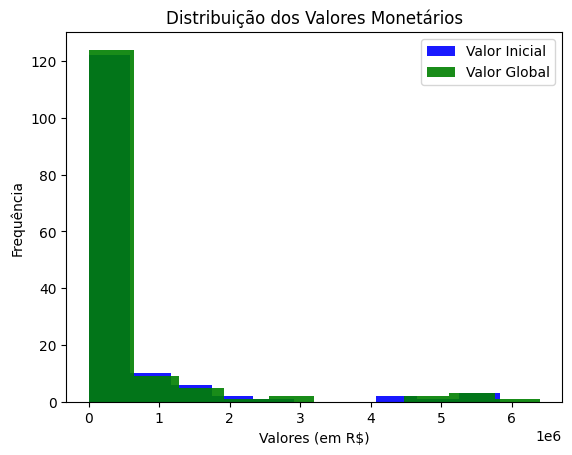

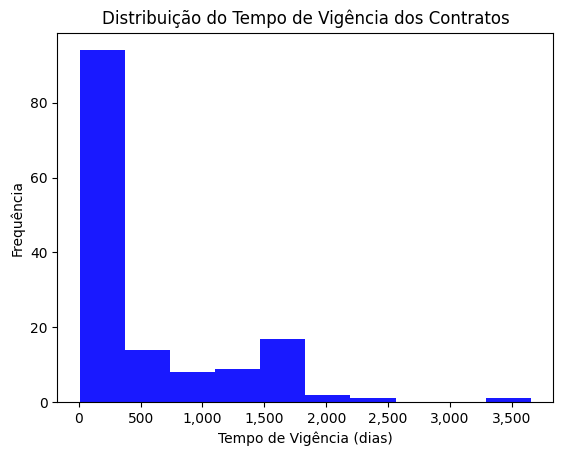

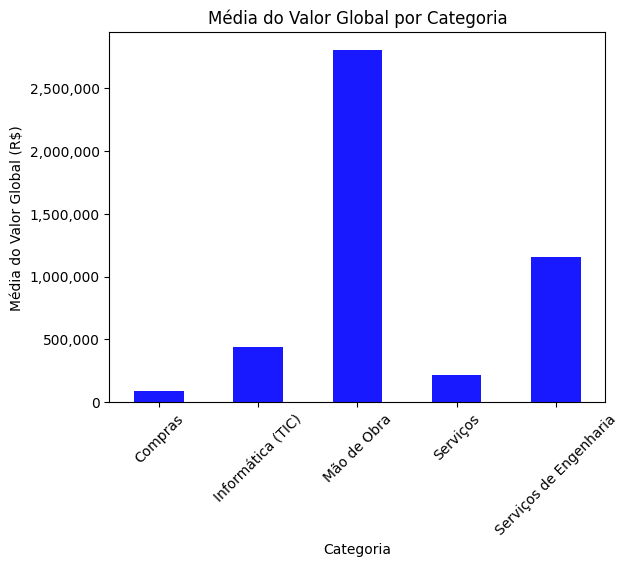

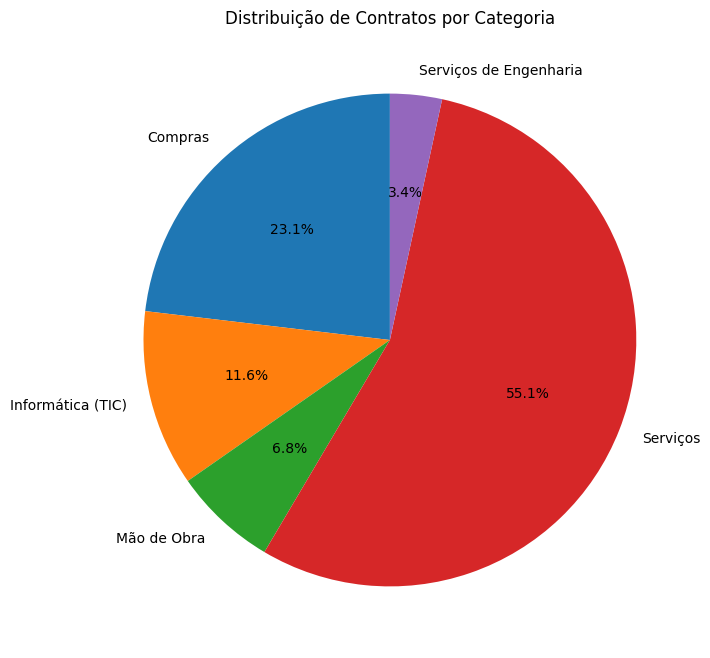

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Função para formatar eixos
def format(x, _):
    return f"{x:,.0f}" 

# Histograma dos valores iniciais e globais
plt.hist(df["valor_inicial"], bins=10, alpha=0.9, color='blue', label='Valor Inicial')
plt.hist(df["valor_global"], bins=10, alpha=0.9, color='green', label='Valor Global')
plt.xlabel("Valores (em R$)")
plt.ylabel("Frequência")
plt.title("Distribuição dos Valores Monetários")
plt.legend()
plt.show()

# Histograma do tempo de vigência
plt.hist(df["tempo_vigencia"], bins=10, alpha=0.9, color='blue')
plt.xlabel("Tempo de Vigência (dias)")
plt.ylabel("Frequência")
plt.title("Distribuição do Tempo de Vigência dos Contratos")
plt.gca().xaxis.set_major_formatter(FuncFormatter(format))
plt.show()

# Gráfico de barras da média por categoria
media_por_categoria.plot(kind="bar", color="blue", alpha=0.9)
plt.xlabel("Categoria")
plt.ylabel("Média do Valor Global (R$)")
plt.title("Média do Valor Global por Categoria")
plt.gca().yaxis.set_major_formatter(FuncFormatter(format))
plt.xticks(rotation=45)
plt.show()

# Gráfico de pizza da média por categoria
quantidade_por_categoria = df.groupby("categoria")["valor_global"].count()
plt.figure(figsize=(8, 8))
plt.pie(
    quantidade_por_categoria, 
    labels=quantidade_por_categoria.index, 
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.tab10.colors
)
plt.title("Distribuição de Contratos por Categoria")
plt.show()



# Análise descritiva 

In [7]:
print("Estatísticas descritivas dos valores:")
print(df[["valor_inicial", "valor_global", "tempo_vigencia"]].describe())

Estatísticas descritivas dos valores:
       valor_inicial  valor_global  tempo_vigencia
count         147.00        147.00          146.00
mean       421564.93     420052.33          653.92
std       1086641.00    1134208.19          664.58
min             0.01          0.00           10.00
25%          2415.50       2222.03          237.75
50%         12540.00       9108.00          365.00
75%        253395.38     144257.72         1019.25
max       5831877.40    6398761.49         3653.00


# Inconsistências

In [6]:
# Procurando NaN por colunas
print("Valores ausentes por coluna:")
print(df.isnull().sum())

# Procurando dados fora do intervalo esperado
print("Contratos com valores negativos:")
print(df[(df["valor_inicial"] < 0) | (df["valor_global"] < 0)])
print("\nContratos com tempo de vigência negativo:")
print(df[df["tempo_vigencia"] < 0])

# Procurando duplicatas
duplicados = df.duplicated(subset=["id"], keep=False)
print(f"Duplicatas encontradas: {duplicados.sum()}")
if duplicados.sum() > 0:
    print(df[duplicados])

# Procurando valores iniciais maiores que valores globais
print("Contratos com valores iniciais maiores que valores globais:")
print(df[df["valor_inicial"] > df["valor_global"]])


Valores ausentes por coluna:
id                            0
receita_despesa               0
numero                        0
contratante                   0
fornecedor                    0
codigo_tipo                   0
tipo                          0
subtipo                     145
prorrogavel                  12
situacao                      0
justificativa_inativo       147
categoria                     0
subcategoria                147
unidades_requisitantes       65
processo                      0
objeto                        0
amparo_legal                  0
informacao_complementar     110
codigo_modalidade             0
modalidade                    0
unidade_compra                0
licitacao_numero              0
sistema_origem_licitacao    147
data_assinatura               0
data_publicacao              16
data_proposta_comercial      75
vigencia_inicio               0
vigencia_fim                  1
valor_inicial                 0
valor_global                  0
num_parcela